In [7]:
### IMPORT NECESSARY LIBRARIES / PACKAGES ###
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Import error metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge


In [2]:
salary_df = pd.read_csv('nba_salaries_data.csv')
salary_df.head()

,Player,GS,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary,Year,Salary cap,%Cap
0,Kevin Garnett,82,9.8,19.6,0.499,0.1,0.5,0.256,9.7,19.1,...,18.3,0.272,6.8,3.3,10.2,10.0,28000000.0,2004,43840000.0,0.638686
1,Dwyane Wade,77,8.2,17.1,0.478,0.2,0.6,0.289,8.0,16.5,...,11.0,0.177,3.9,0.7,4.6,4.9,27696430.0,2005,43870000.0,0.631330
2,Kevin Garnett,82,9.1,18.1,0.502,0.2,0.9,0.282,8.8,17.2,...,15.6,0.225,6.0,2.4,8.4,8.7,25200000.0,2003,40271000.0,0.625760
3,Kobe Bryant,82,10.6,23.5,0.451,1.5,4.0,0.383,9.1,19.5,...,14.9,0.210,6.3,0.7,7.1,7.7,23571429.0,2003,40271000.0,0.585320
4,Kobe Bryant,64,7.9,18.1,0.438,1.1,3.3,0.327,6.8,14.8,...,10.7,0.210,5.1,0.5,5.6,4.7,24749999.0,2004,43840000.0,0.564553


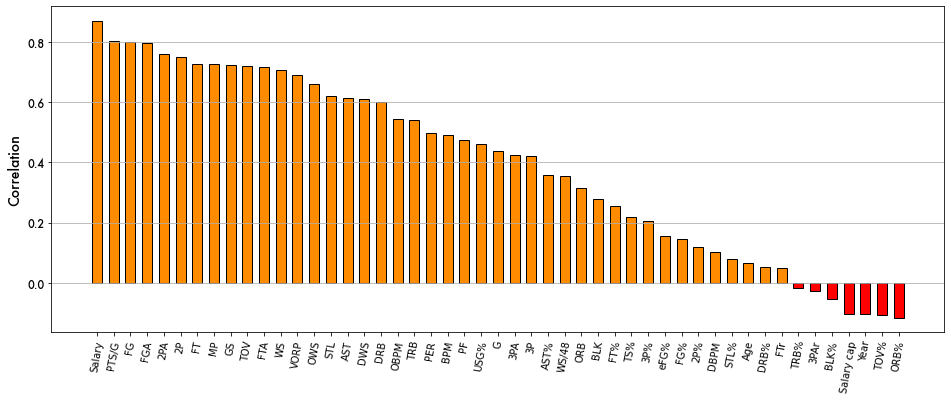

In [3]:
corr_df = salary_df.corr().sort_values('%Cap', ascending = False)

plt.figure(figsize = (16, 6))

plt.bar(corr_df[corr_df['%Cap'] >= 0].index[1:], corr_df[corr_df['%Cap'] >= 0]['%Cap'][1:],
                        width = 0.6, color = 'darkorange', edgecolor = 'black')
plt.bar(corr_df[corr_df['%Cap'] < 0].index, corr_df[corr_df['%Cap'] < 0]['%Cap'],
                        width = 0.6, color = 'red', edgecolor = 'black')

#plt.plot(range(1, len(corr_df)), corr_df['Share'][1:], alpha = 0.5, linestyle = '-', c = 'black')
plt.xticks(rotation = 80)
plt.yticks(fontname = 'futura', size = 11)
plt.ylabel('Correlation', fontname = 'futura', size = 14)
plt.grid(axis = 'y')
plt.show()

In [8]:
features = ['PTS/G', 'FG', 'MP', 'GS', 'FTA', 'WS', 'VORP', 'OWS', 'AST', 'TRB', 'PER', 'BPM', 'USG%']
target = '%Cap'

In [34]:
### SPLIT INTO TEST / TRAIN ###

train_data = salary_df[salary_df['Year'] < 2022]
test_data = salary_df[salary_df['Year'] == 2022]
test_data = test_data[(test_data['MP'] >= 7) & (test_data['G'] >= 10)]

In [35]:
# Create a function to test different ML models
def Salary_ML(model, name = '-'):

    model.fit(train_data[features], train_data[target]) # Fit the input model to train data
    pred = model.predict(test_data[features])
    
    df = pd.DataFrame([[name, mse(test_data[target], pred), mae(test_data[target], pred), r2(test_data[target], pred)]],
                     columns = ['Model', 'MSE', 'MAE', 'R2'])
    
    return df

In [36]:
rfr = RandomForestRegressor()
svr = SVR()
reg = LinearRegression()
xgbreg = XGBRegressor()
ridge = Ridge()

model_tuning = [Salary_ML(model, name) for model, name in zip([rfr, svr, reg, xgbreg, ridge], 
                                            ['Random Forest', 'SVR', 'Linear Reg', 'XGB Reg', 'Ridge'])]
model_tuning = pd.concat(model_tuning)
model_tuning.head()

,Model,MSE,MAE,R2
0,Random Forest,0.002304,0.032974,0.705241
0,SVR,0.006956,0.076704,0.110033
0,Linear Reg,0.002555,0.035866,0.673029
0,XGB Reg,0.002369,0.032539,0.696895
0,Ridge,0.002555,0.035868,0.673029


The analysis above shows that the Random Forest Regression model is most suitable

In [37]:
rfr.fit(train_data[features], train_data[target])
test_data = test_data.assign(pred = rfr.predict(test_data[features]))

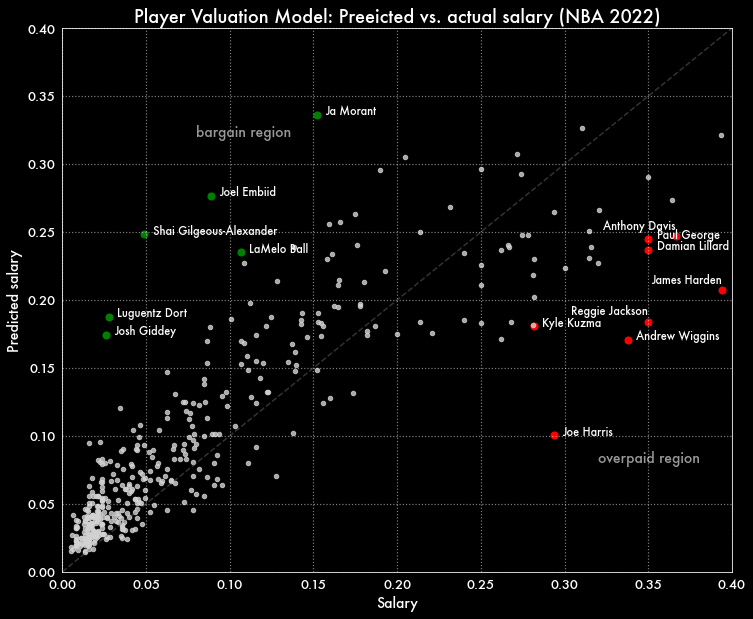

In [51]:
fig, ax = plt.subplots(figsize = (12, 10), facecolor = 'black')
plt.gca().set_facecolor('black')
ax.spines['left'].set_color('white'); ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white'); ax.spines['top'].set_color('white') 

for x, y, player in zip(test_data['%Cap'], test_data['pred'], test_data['Player']):

    plt.scatter(x, y, s = 20, color = 'lightgray', alpha = 0.8)
    if player in ['Anthony Davis', 'James Harden', 'Reggie Jackson'] :
        plt.annotate(player, xy = (x, y + 0.005), size = 11, fontname = 'futura', color = 'white', ha = 'right')
        plt.scatter(x, y, s = 50, color = 'red')

    elif x - y > 0.1:
        plt.annotate(player, xy = (x + 0.005, y), size = 11, fontname = 'futura', color = 'white')
        plt.scatter(x, y, s = 50, color = 'red')

    elif y - x > 0.12 :
        plt.annotate(player, xy = (x + 0.005, y), size = 11, fontname = 'futura', color = 'white')
        plt.scatter(x, y, s = 50, color = 'green')


plt.plot([0, 0.4], [0, 0.4], c = 'gray', alpha = 0.4, linestyle = '--')

### FIGURE FORMATTING ###
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])
plt.grid(axis = 'both', alpha = 0.5, linestyle = ':', linewidth = 1.2, color = 'white') # Add a grid
plt.xticks(fontname = 'futura', size = 13, color = 'white') # Set x-ticks
plt.yticks(fontname = 'futura', size = 13, color = 'white') # Set y-ticks
plt.xlabel('Salary', fontname = 'futura', size = 14, color = 'white')
plt.ylabel('Predicted salary', fontname = 'futura', size = 14, color = 'white')
plt.annotate('overpaid region', xy = (0.8, 0.2), xycoords = 'axes fraction', size = 14, fontname = 'futura', alpha = 0.6, color = 'white')
plt.annotate('bargain region', xy = (0.2, 0.8), xycoords = 'axes fraction', size = 14, fontname = 'futura', alpha = 0.6, color = 'white')
plt.title('Player Valuation Model: Preeicted vs. actual salary (NBA 2022)', fontname = 'futura', size = 18, color = 'white')

plt.savefig('Valuation_model_2022.jpeg', dpi = 400)
plt.show()